# Sieci Neuronowe - lista 2
## Jakub Czajkowski 272709
---
### Opis zaimplementowanego kodu

1. Przygotowanie danych  
    - Wczytanie macierzy cech i etykiet z pliku pickle.  
    - Konwersja etykiety na problem binarny (1 jeśli num > 0, inaczej 0).  
    - Podział na zbiór treningowy (80%) i testowy (20%) z zachowaniem proporcji klas (stratify).  
    - Normalizacja cech na podstawie średniej i odchylenia standardowego zbioru treningowego (unormowane X_train, X_test).

2. Inicjalizacja modelu i funkcje pomocnicze  
    - Wagi W (shape: n_features x 1) i bias b inicjalizowane losowo.  
    - Funkcja sigmoid(z), predict(X) zwracająca prawdopodobieństwa.  
    - compute_loss(X, y) — Binary Cross-Entropy (z zabezpieczeniem przed log(0)).  
    - compute_gradients(X, y) — gradienty dW, db oraz wartość straty.  
    - train(X, y, learning_rate, max_epochs, tol) — optymalizacja metodą spadku gradientu (aktualizacja W, b), zapisywanie przebiegu strat (losses) i kryterium zbieżności.

3. Funkcje ewaluacji  
    - calculate_metrics(X, y) — predykcja progowa (0.5) i obliczenie accuracy, precision, F1 (użycie sklearn.metrics).

4. Trening i raport wyników  
    - Ustawienia treningu (learning_rate, max_epochs).  
    - Uruchomienie train na X_train, y_train, otrzymanie listy losses.  
    - Obliczenie i wypisanie metryk dla zbiorów treningowego i testowego (accuracy, precision, F1).  
    - Wizualizacja przebiegu straty w czasie epok (wykres losses przy użyciu matplotlib).

Uwagi praktyczne: hiperparametry do dostrojenia — learning_rate i max_epochs; kluczowe zmienne do monitorowania: losses (lista strat), W, b oraz metryki train_* i test_*.

### Kod źródłowy

## 1. Przygotowanie danych
Wczytanie danych z poprzedniej listy, konwersja na problem binarny klasyfikacji, podział na zbiór treningowy (80%) i testowy (20%), oraz normalizacja cech na zbiorze treningowym.

In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(42)

with open('data.pkl', 'rb') as f:
    X_matrix, y = pickle.load(f)

y = y['num'].apply(lambda v: 1 if v > 0 else 0)

X_train, X_test, y_train, y_test = train_test_split(
    X_matrix, y, test_size=0.2, random_state=42, stratify=y
)

X_train = np.asarray(X_train, dtype=np.float64)
X_test = np.asarray(X_test, dtype=np.float64)
y_train = np.asarray(y_train, dtype=np.float64)
y_test = np.asarray(y_test, dtype=np.float64)

train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0, ddof=0)
train_std[train_std == 0] = 1.0  # Avoid division by zero for constant features
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std


## 2. Inicjalizacja modelu i funkcje pomocnicze
Zdefiniowanie parametrów modelu (wagi i obciążenie inicjalizowane losowo), implementacja funkcji sigmoid, predykcji oraz obliczania Binary Cross-Entropy loss. Funkcje do obliczania gradientów oraz algorytm treningu z metodą gradientu prostego (SGD).

In [ ]:
n_features = X_matrix.shape[1]
W = np.random.uniform(-1, 1, (n_features, 1))
b = np.random.uniform(-1, 1)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X):
    z = np.dot(X, W) + b
    return sigmoid(z)

def compute_loss(X, y):
    p = predict(X)
    y_col = y.reshape(-1, 1)
    L = - (y_col * np.log(p + 1e-15) + (1 - y_col) * np.log(1 - p + 1e-15))
    return np.mean(L)

def compute_gradients(X, y):
    p = predict(X)
    # Ensure y is a column vector
    y_col = y.reshape(-1, 1)
    error = p - y_col
    
    dW = np.dot(X.T, error) / X.shape[0]
    db = np.sum(error) / X.shape[0]
    
    loss = compute_loss(X, y)
    return dW, db, loss

def train(X, y, learning_rate=0.01, max_epochs=1000, tol=1e-6):
    losses = []
    last_loss = float('inf')

    for epoch in range(max_epochs):
        dW, db, loss = compute_gradients(X, y)
        
        # Update weights and bias
        global W, b
        W -= learning_rate * dW
        b -= learning_rate * db
        
        losses.append(loss)
        
        # Print progress
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {loss:.6f}")
            
        # Check for convergence
        if abs(last_loss - loss) < tol:
            print(f"Converged at epoch {epoch + 1}")
            break
        last_loss = loss
        
    return losses

## 3. Funkcje ewaluacji modelu
Implementacja funkcji do obliczania metryk klasyfikacji: dokładności (accuracy), precyzji i F1-score. Metryki obliczane dla zarówno zbioru treningowego jak i testowego.

In [23]:
from sklearn.metrics import precision_score, f1_score

def calculate_metrics(X, y):
    p = predict(X)
    y_pred = (p >= 0.5).astype(int)
    y_col = y.reshape(-1, 1)
    
    acc = np.mean(y_pred == y_col)
    precision = precision_score(y_col, y_pred)
    f1 = f1_score(y_col, y_pred)
    
    return acc, precision, f1

## 4. Trening modelu i ewaluacja wyników
Trening regresora logistycznego na zbiorze treningowym z użyciem metody gradientu prostego. Ocena wydajności modelu na zbiorze treningowym i testowym. Wizualizacja przebiegu funkcji straty w trakcie treningu.

Epoch 100/2000, Loss: 0.386730
Epoch 200/2000, Loss: 0.347452
Epoch 300/2000, Loss: 0.339233
Epoch 400/2000, Loss: 0.336751
Epoch 500/2000, Loss: 0.335747
Epoch 600/2000, Loss: 0.335261
Epoch 700/2000, Loss: 0.335006
Epoch 800/2000, Loss: 0.334868
Converged at epoch 803
--- Training Metrics ---
Accuracy: 0.8554
Precision: 0.8654
F1-score: 0.8372

--- Test Metrics ---
Accuracy: 0.8361
Precision: 0.8000
F1-score: 0.8276


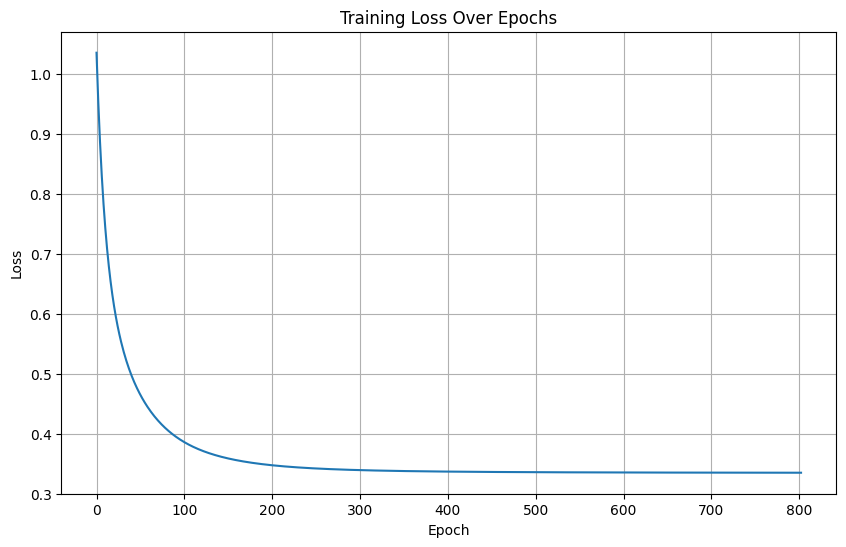

In [24]:
# Train the model
learning_rate = 0.1
max_epochs = 2000
losses = train(X_train, y_train, learning_rate=learning_rate, max_epochs=max_epochs)

# Evaluate the model
train_acc, train_precision, train_f1 = calculate_metrics(X_train, y_train)
test_acc, test_precision, test_f1 = calculate_metrics(X_test, y_test)

print("--- Training Metrics ---")
print(f"Accuracy: {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"F1-score: {train_f1:.4f}")
print("\n--- Test Metrics ---")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"F1-score: {test_f1:.4f}")


# Plot the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()